
MNIST ("Modified National Institute of Standards and Technology") is computer vision dataset released in 1999. It contains data of handwritten images and it is the "de facto" benchmark for classification algorithms. The goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.



![](http://corochann.com/wp-content/uploads/2017/02/mnist_plot.png)

# The data

The data description can be found at [Kaggle](https://www.kaggle.com/c/digit-recognizer/data):

> The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

> **Each image is 28 pixels in height and 28 pixels in width**, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. **This pixel-value is an integer between 0 and 255, inclusive**.

> The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

> Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn import metrics

In [0]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

EPOCHS_TO_TRAIN = 10

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 8

In [0]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
]), )

dataloader_args = dict(shuffle=True, batch_size=64, num_workers=1)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

# Exploration

## What does a single digit looks like?

Computers don't really know what an image is. They know about numbers. So, we encode images into numbers:

![](https://cdn-images-1.medium.com/max/1600/1*zY1qFB9aFfZz66YxxoI2aw.gif)

(Source: [Adam Geitgey](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))

## Convert digit data from matrix to vector

![](https://cdn-images-1.medium.com/max/2000/1*UDgDe_-GMs4QQbT8UopoGA.png)

(Source: [Adam Geitgey](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))

In [0]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 520)
        self.l2 = nn.Linear(520, 320)
        self.l3 = nn.Linear(320, 240)
        self.l4 = nn.Linear(240, 120)
        self.l5 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)

In [0]:
model = Model()

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    criterion = criterion.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
model

Model(
  (l1): Linear(in_features=784, out_features=520)
  (l2): Linear(in_features=520, out_features=320)
  (l3): Linear(in_features=320, out_features=240)
  (l4): Linear(in_features=240, out_features=120)
  (l5): Linear(in_features=120, out_features=10)
)

In [10]:
train_loss = []
test_loss = []


for epoch in range(EPOCHS_TO_TRAIN):
    model.train()
    e_train_loss = []
    for data, target in train_loader:
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()

        y_pred = model(data) 

        loss = criterion(y_pred, target)
        e_train_loss.append(loss.data[0])
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
    mean_train_loss = np.mean(e_train_loss)
    train_loss.append(mean_train_loss)
        
        
        
    model.eval()
    e_test_loss = []
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target, volatile=True)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss = criterion(output, target).data[0]
        e_test_loss.append(loss)
        
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    mean_test_loss = np.mean(e_test_loss)
    test_loss.append(mean_test_loss)
    
    print(f"""
    ######### Epoch {epoch + 1} #########\n
    average train loss: {mean_train_loss}
    average test loss: {mean_test_loss}
    test accuracy: {correct}/{len(test_loader.dataset)} {100. * correct / len(test_loader.dataset)}%
""")


    ######### Epoch 1 #########

    average train loss: 0.27918842042893616
    average test loss: 0.11950360098557108
    test accuracy: 9641/10000 96.41%


    ######### Epoch 2 #########

    average train loss: 0.10182493776758152
    average test loss: 0.08800359222160023
    test accuracy: 9735/10000 97.35%


    ######### Epoch 3 #########

    average train loss: 0.06996005646654092
    average test loss: 0.08895643220348343
    test accuracy: 9727/10000 97.27%


    ######### Epoch 4 #########

    average train loss: 0.055275989217814736
    average test loss: 0.09834915499208839
    test accuracy: 9721/10000 97.21%


    ######### Epoch 5 #########

    average train loss: 0.042018514321143945
    average test loss: 0.07706559310625692
    test accuracy: 9769/10000 97.69%


    ######### Epoch 6 #########

    average train loss: 0.03621354983297429
    average test loss: 0.09753723492383197
    test accuracy: 9731/10000 97.31%


    ######### Epoch 7 #########

    averag

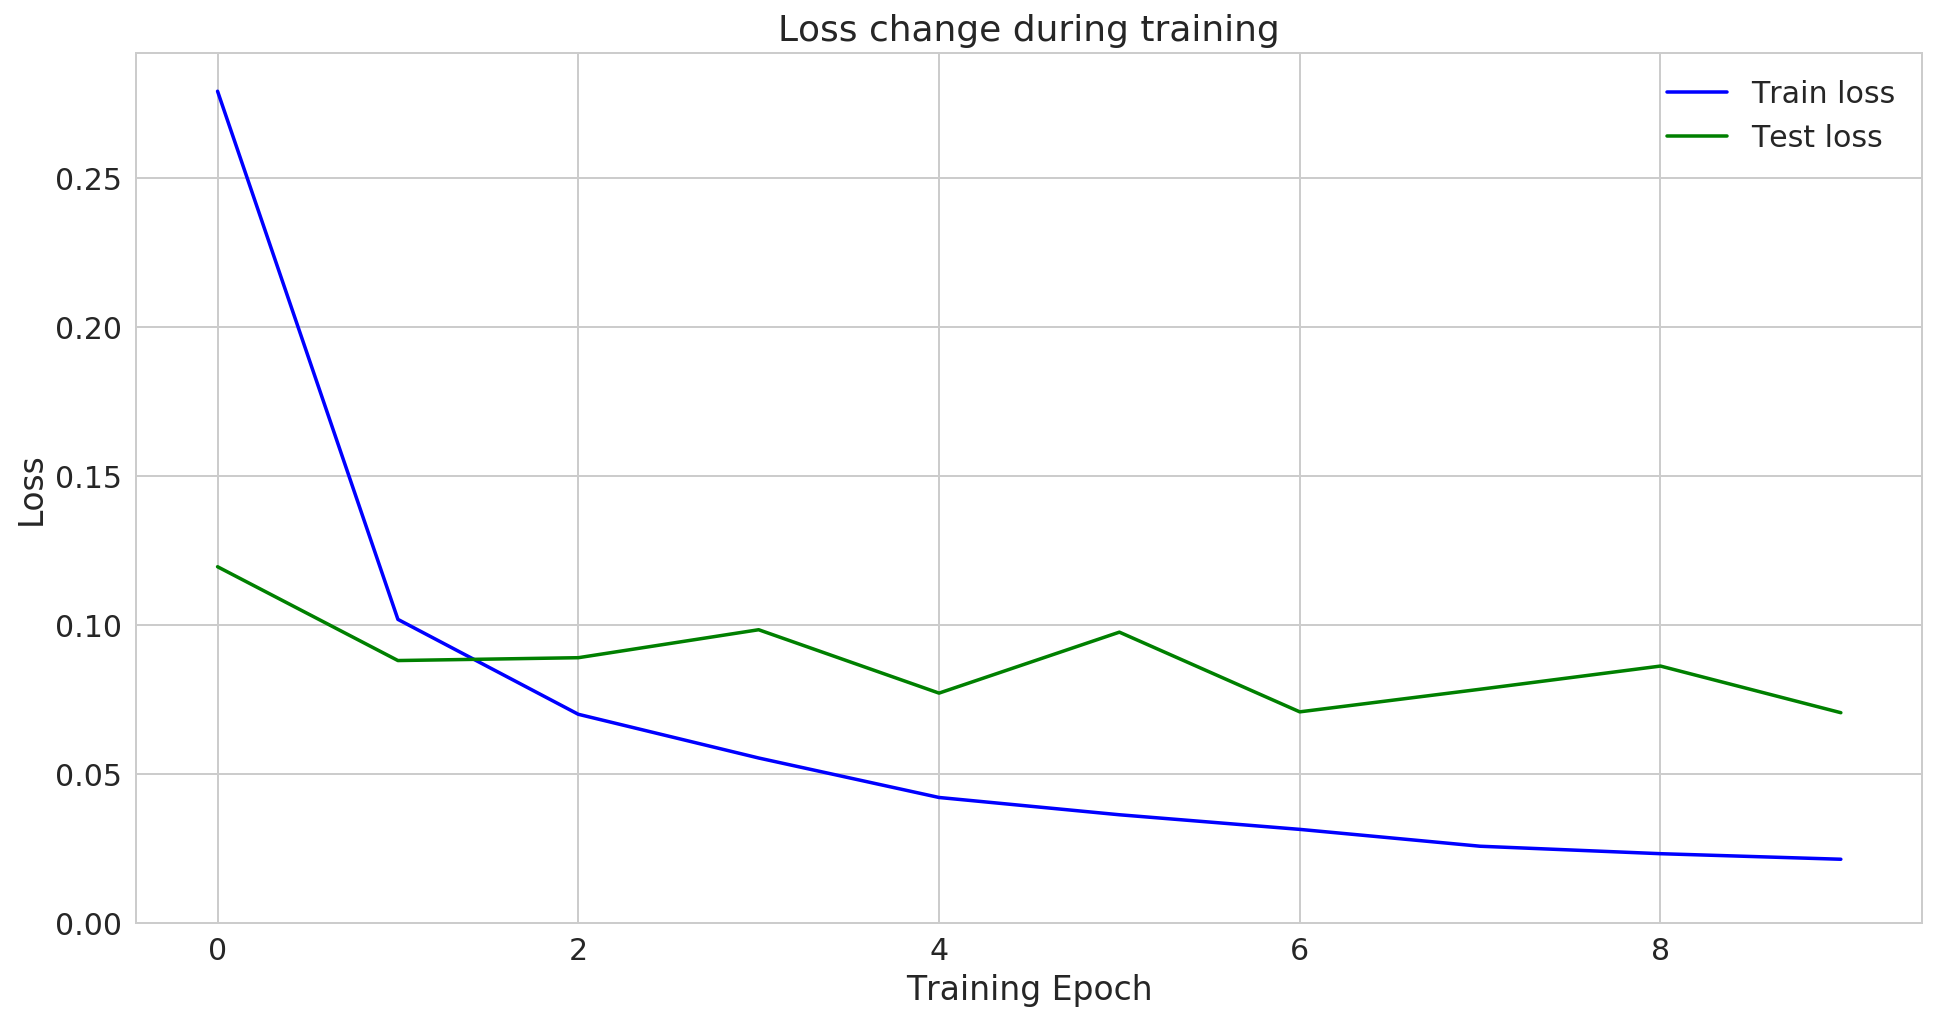

In [11]:
plt.figure(figsize=(16, 8))

plt.plot(train_loss, "b", label="Train loss")

plt.plot(test_loss, "g", label="Test loss")

plt.title("Loss change during training")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show();

In [0]:
model.eval()

ys = []
y_hats = []

for data, target in test_loader:
    data= Variable(data, volatile=True)
    
    if torch.cuda.is_available():
        data = data.cuda()
    
    output = model(data)

    pred = output.data.max(1, keepdim=True)[1]
    
    if torch.cuda.is_available():
        pred = pred.cpu()
    
    pred = pred.numpy().flatten()
    
    y_hats.extend(pred)
    ys.extend(target)

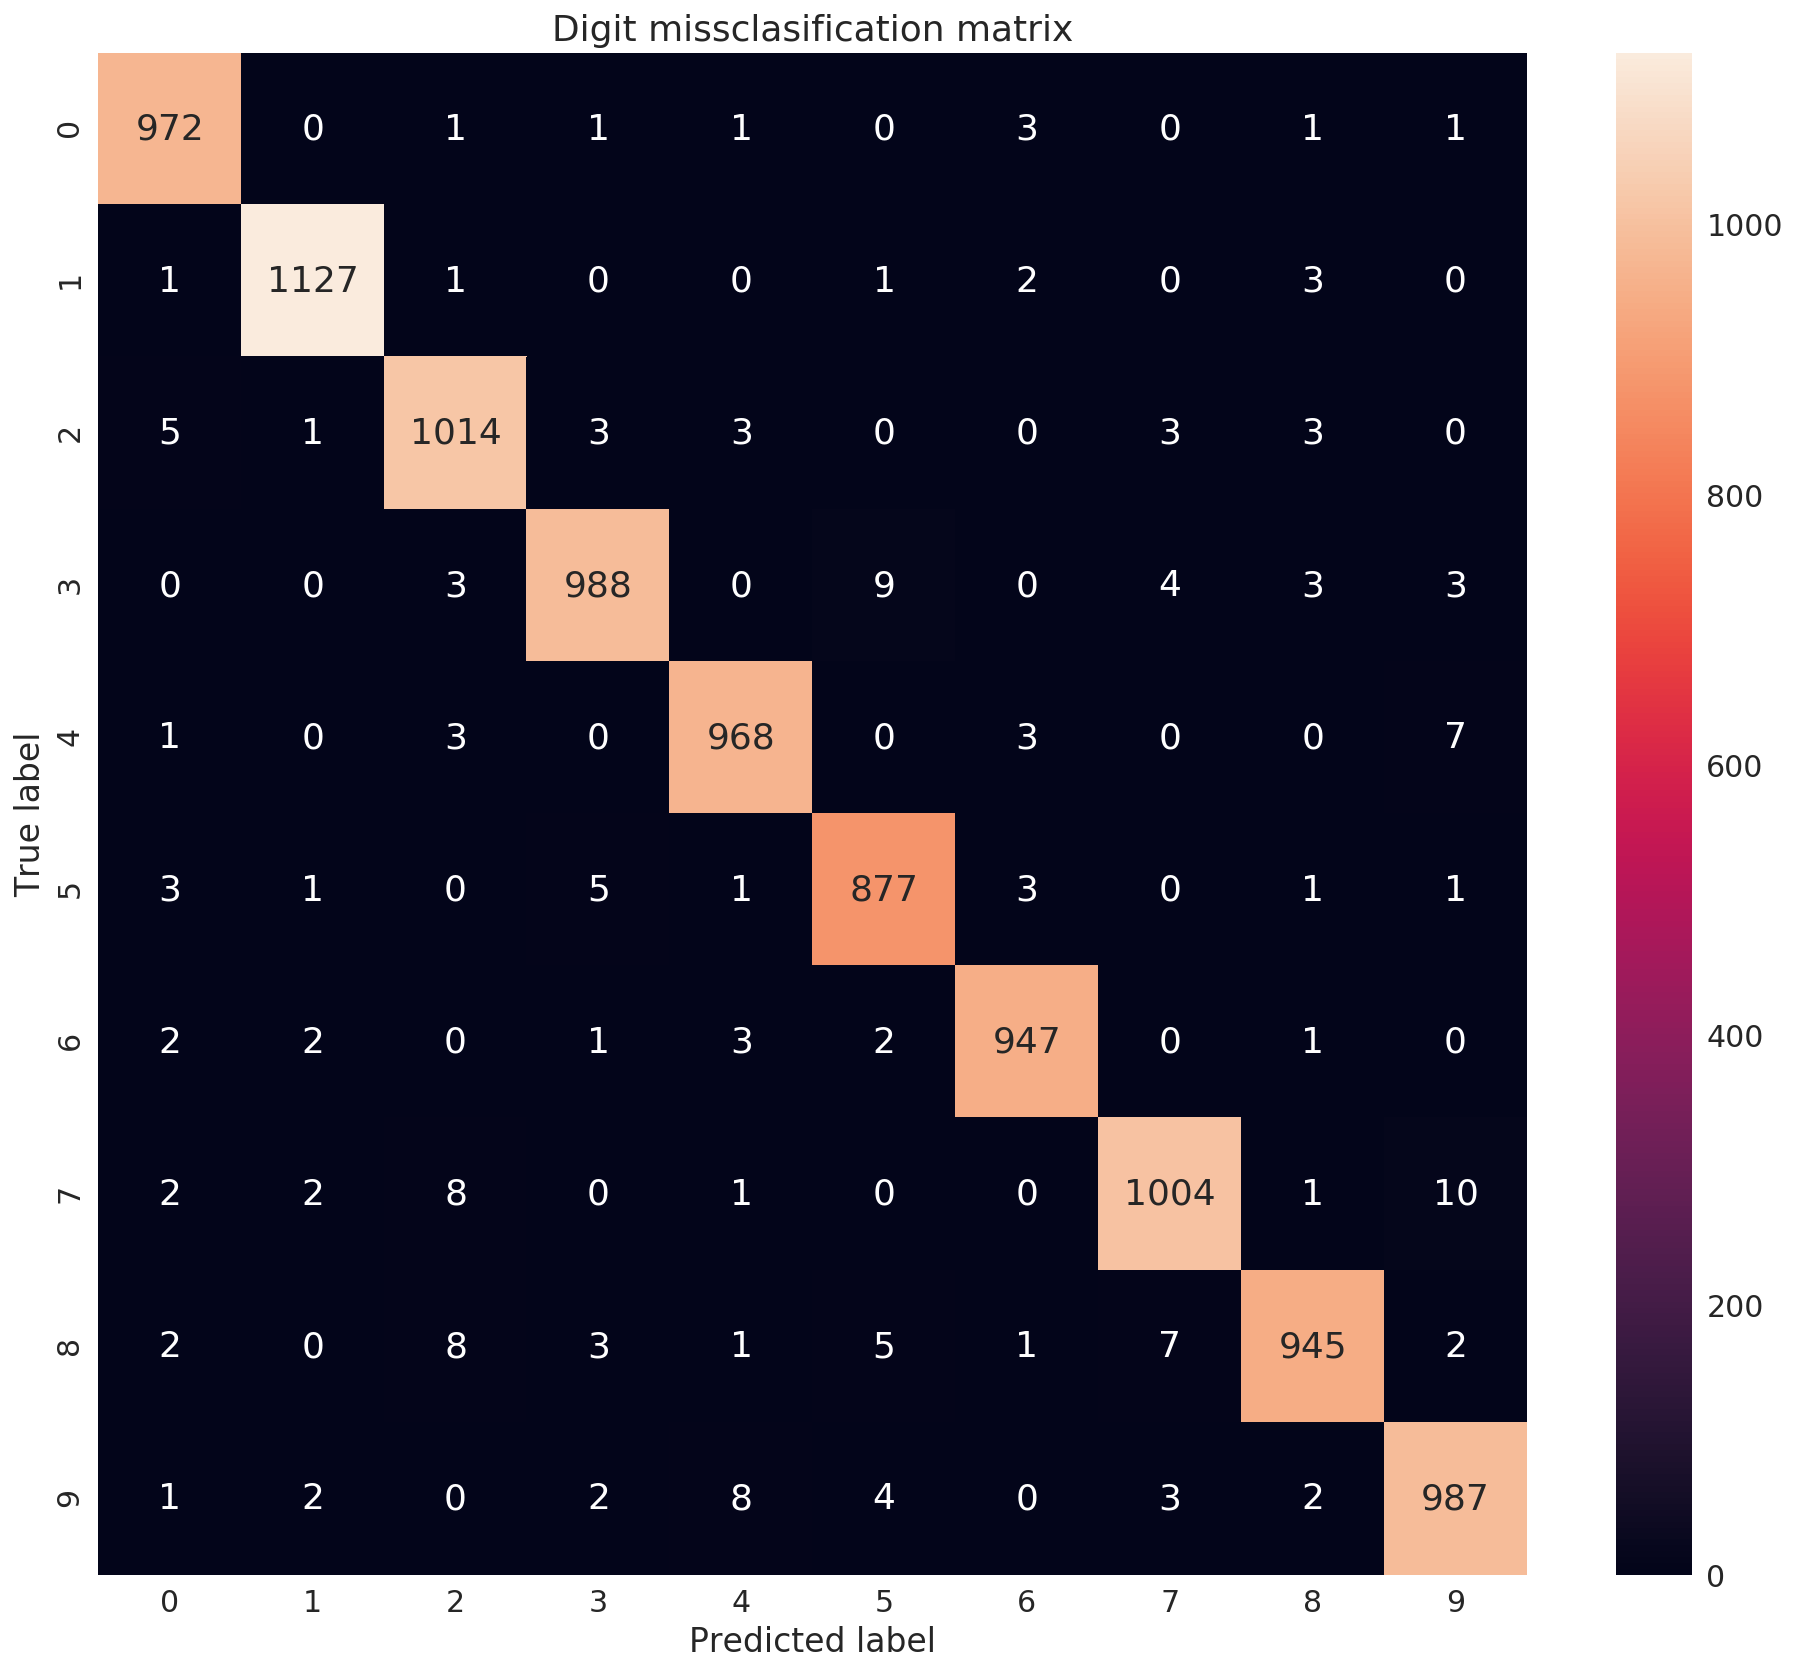

In [13]:
confusion_matrix = metrics.confusion_matrix(ys, y_hats)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Digit missclasification matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

# Convolutional Neural Networks

When talking about image-related problems - Convolutional Neural Networks (CNNs) are the go-to model these days. The main advantage of CNNs compared to previous models is that they detect important features without human supervision.

Somewhat general architecture for CNNs is the following:

![](https://cdn-images-1.medium.com/max/2000/1*uulvWMFJMidBfbH9tMVNTw@2x.png)

We have an input image that we work on. The architecture consists of (Conv, Pool) pair of layers, followed by couple of Fully-connected (or other) layers.

You can think of CNNs as two part models:

- Feature extractor (Conv & Pool layers)
- Classifier/Regressor etc (Fully-connected layers)

## CNNs Components

### Convolutions

Convolutions are the main building block of CNNs (hence the name) and are (really) simple operations that strive to merge two sets of data. 

![](https://cdn-images-1.medium.com/max/2000/1*cTEp-IvCCUYPTT0QpE3Gjg@2x.png)

Here we have *input data* and a *Filter/kernel*. This is called a $3 \times 3$ convolution due to the size of the filter.

The convolution operation is performed by sliding the kernel over the input:

![](https://cdn-images-1.medium.com/max/2000/1*VVvdh-BUKFh2pwDD0kPeRA@2x.gif)

At every position, we do element-wise matrix multiplication and sum the result. This sum goes into the feature map (the matrix on the right).

Usually multiple convolutions are performed on an input using a distinct filter resulting into unique feature map. All features maps are then stacked and this becomes the final output of our convolution layer:

![](https://cdn-images-1.medium.com/max/1600/1*45GSvnTvpHV0oiRr78dBiw@2x.png)

#### Stride

Stride specifies how much we move (or skip rows/columns) the filter at each step. Bigger stride allows for less overlap and smaller feature map:

![](https://cdn-images-1.medium.com/max/1600/1*4wZt9G7W7CchZO-5rVxl5g@2x.gif)

#### Padding

Sometimes, we want to maintain the same dimensionality in our feature maps. We can use padded values (equal to 0) to surround our input:

![](https://cdn-images-1.medium.com/max/1600/1*W2D564Gkad9lj3_6t9I2PA@2x.gif)

## Pooling


Pooling is performed to reduce dimensionality of convolution layers (reduce parameters -> try to minimize overfitting). Pooling layers reduces the height and width of each feature map (depth stays untouched). Max pooling is the most common pooling operation. It simply takes the max value in the pooling window:

![](https://cdn-images-1.medium.com/max/1600/1*ReZNSf_Yr7Q1nqegGirsMQ@2x.png)

# CNNS in PyTorch

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.fc1 = nn.Linear(500, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        c1 = self.conv1(x)
        x = F.relu(F.max_pool2d(c1, 2))
        c2 = self.conv2(x)
        x = F.relu(F.max_pool2d(c2, 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [0]:
model = CNN()

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    criterion = criterion.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [66]:
model

CNN(
  (conv1): Conv2d (1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d (10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=100)
  (fc2): Linear(in_features=100, out_features=10)
)

In [67]:
train_loss = []
test_loss = []


for epoch in range(EPOCHS_TO_TRAIN):
    model.train()
    e_train_loss = []
    for data, target in train_loader:
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()

        y_pred = model(data)

        loss = criterion(y_pred, target)
        e_train_loss.append(loss.data[0])
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
    mean_train_loss = np.mean(e_train_loss)
    train_loss.append(mean_train_loss)
        
    model.eval()
    e_test_loss = []
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target, volatile=True)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        

        
        loss = criterion(output, target).data[0]
        e_test_loss.append(loss)
        
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    mean_test_loss = np.mean(e_test_loss)
    test_loss.append(mean_test_loss)
    
    print(f"""
    ######### Epoch {epoch + 1} #########\n
    average train loss: {mean_train_loss}
    average test loss: {mean_test_loss}
    test accuracy: {correct}/{len(test_loader.dataset)} {100. * correct / len(test_loader.dataset)}%
""")


    ######### Epoch 1 #########

    average train loss: 0.29626290873487365
    average test loss: 0.09732032469977998
    test accuracy: 9693/10000 96.93%


    ######### Epoch 2 #########

    average train loss: 0.08723757703548302
    average test loss: 0.058256677690015475
    test accuracy: 9813/10000 98.13%


    ######### Epoch 3 #########

    average train loss: 0.06075356634599822
    average test loss: 0.05290655470245583
    test accuracy: 9824/10000 98.24%


    ######### Epoch 4 #########

    average train loss: 0.046667477064358906
    average test loss: 0.04648224112524348
    test accuracy: 9858/10000 98.58%


    ######### Epoch 5 #########

    average train loss: 0.03907396263286058
    average test loss: 0.05522864106686631
    test accuracy: 9823/10000 98.23%


    ######### Epoch 6 #########

    average train loss: 0.03252769657361037
    average test loss: 0.035483344345335746
    test accuracy: 9885/10000 98.85%


    ######### Epoch 7 #########

    avera

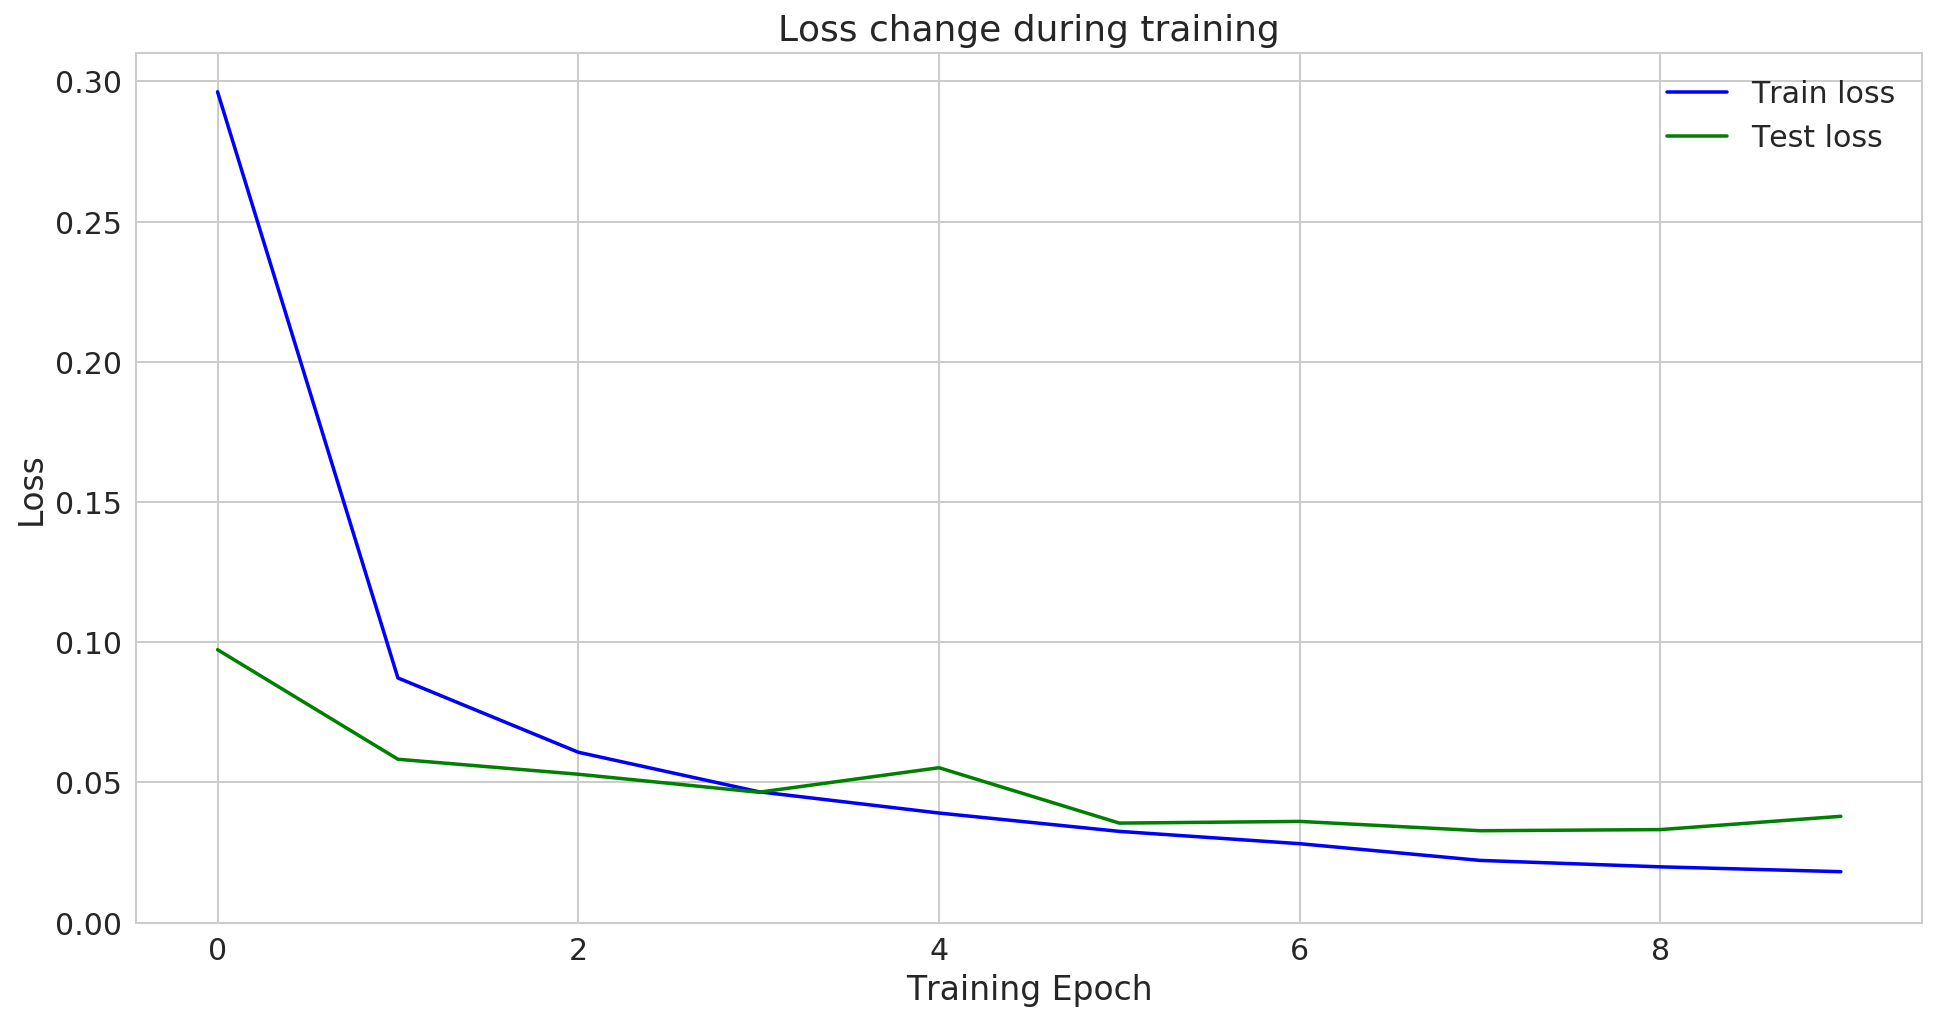

In [68]:
plt.figure(figsize=(16, 8))

plt.plot(train_loss, "b", label="Train loss")

plt.plot(test_loss, "g", label="Test loss")

plt.title("Loss change during training")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show();

In [0]:
model.eval()

ys = []
y_hats = []

for data, target in test_loader:
    data= Variable(data, volatile=True)
    
    if torch.cuda.is_available():
        data = data.cuda()
    
    output = model(data)

    pred = output.data.max(1, keepdim=True)[1]
    
    if torch.cuda.is_available():
        pred = pred.cpu()
    
    pred = pred.numpy().flatten()
    
    y_hats.extend(pred)
    ys.extend(target)

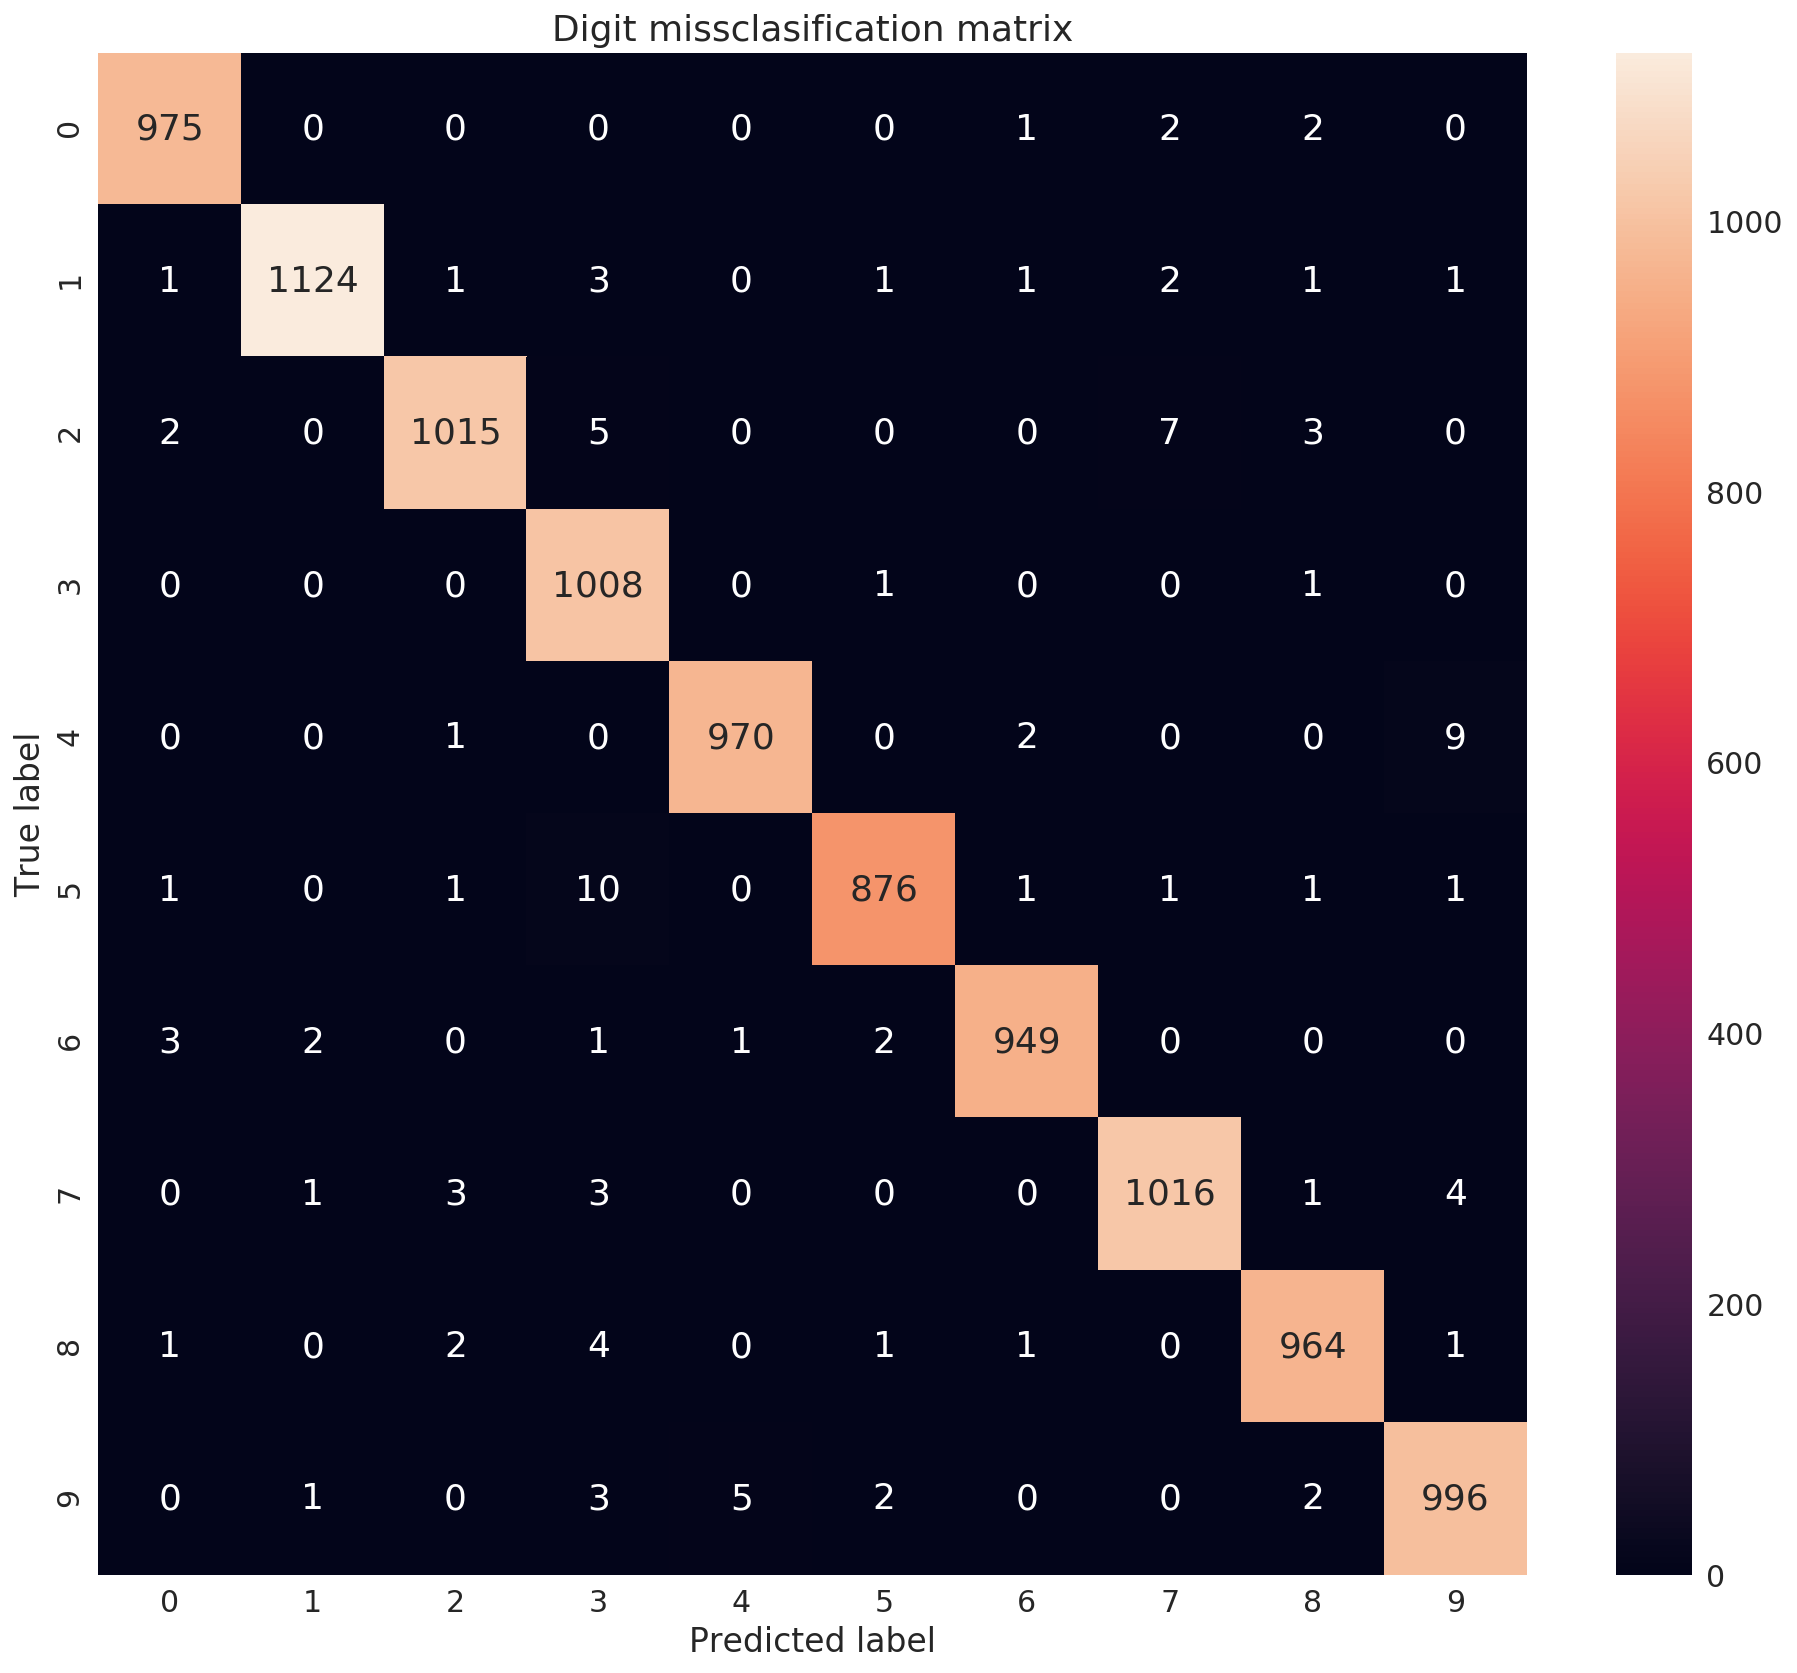

In [70]:
confusion_matrix = metrics.confusion_matrix(ys, y_hats)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Digit missclasification matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

# Dropout

Dropout is a technique which allows us to squeeze even more accuracy from our models. It does that by randomly switching neurons (and their connections) on and off during training (and sometimes during evaluation/prediction).

Surprisingly, Dropout allows us to regularize our models and thus prevent overfitting. Training using Dropout forces the neurons of our neural net to be "more independent" - we constraint our model by removing some of its parameters and still forcing it to give correct predictions.

![](https://cdn-images-1.medium.com/max/2000/1*7LrJUUXIO8ewrbuUIbUkXQ@2x.png)

In [0]:
class CNNDrop(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(500, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        c1 = self.conv1(x)
        x = F.relu(F.max_pool2d(c1, 2))
        c2 = self.conv2(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(c2), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        return self.fc2(x)

In [0]:
model = CNNDrop()

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    criterion = criterion.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [80]:
model

CNNDrop(
  (conv1): Conv2d (1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d (10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2)
  (fc1): Linear(in_features=500, out_features=100)
  (fc2): Linear(in_features=100, out_features=10)
)

In [81]:
train_loss = []
test_loss = []


for epoch in range(EPOCHS_TO_TRAIN):
    model.train()
    e_train_loss = []
    for data, target in train_loader:
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()

        y_pred = model(data)

        loss = criterion(y_pred, target)
        e_train_loss.append(loss.data[0])
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
    mean_train_loss = np.mean(e_train_loss)
    train_loss.append(mean_train_loss)
        
    model.eval()
    e_test_loss = []
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target, volatile=True)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss = criterion(output, target).data[0]
        e_test_loss.append(loss)
        
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    mean_test_loss = np.mean(e_test_loss)
    test_loss.append(mean_test_loss)
    
    print(f"""
    ######### Epoch {epoch + 1} #########\n
    average train loss: {mean_train_loss}
    average test loss: {mean_test_loss}
    test accuracy: {correct}/{len(test_loader.dataset)} {100. * correct / len(test_loader.dataset)}%
""")


    ######### Epoch 1 #########

    average train loss: 0.2908326002485208
    average test loss: 0.08294187562101206
    test accuracy: 9738/10000 97.38%


    ######### Epoch 2 #########

    average train loss: 0.09225394779335716
    average test loss: 0.05164455582097078
    test accuracy: 9830/10000 98.3%


    ######### Epoch 3 #########

    average train loss: 0.06878737832651909
    average test loss: 0.04508021427615053
    test accuracy: 9849/10000 98.49%


    ######### Epoch 4 #########

    average train loss: 0.05408573667131571
    average test loss: 0.041697977454798994
    test accuracy: 9868/10000 98.68%


    ######### Epoch 5 #########

    average train loss: 0.04482849584475382
    average test loss: 0.03856518861072458
    test accuracy: 9874/10000 98.74%


    ######### Epoch 6 #########

    average train loss: 0.03911454125301543
    average test loss: 0.034538743566650494
    test accuracy: 9887/10000 98.87%


    ######### Epoch 7 #########

    average 

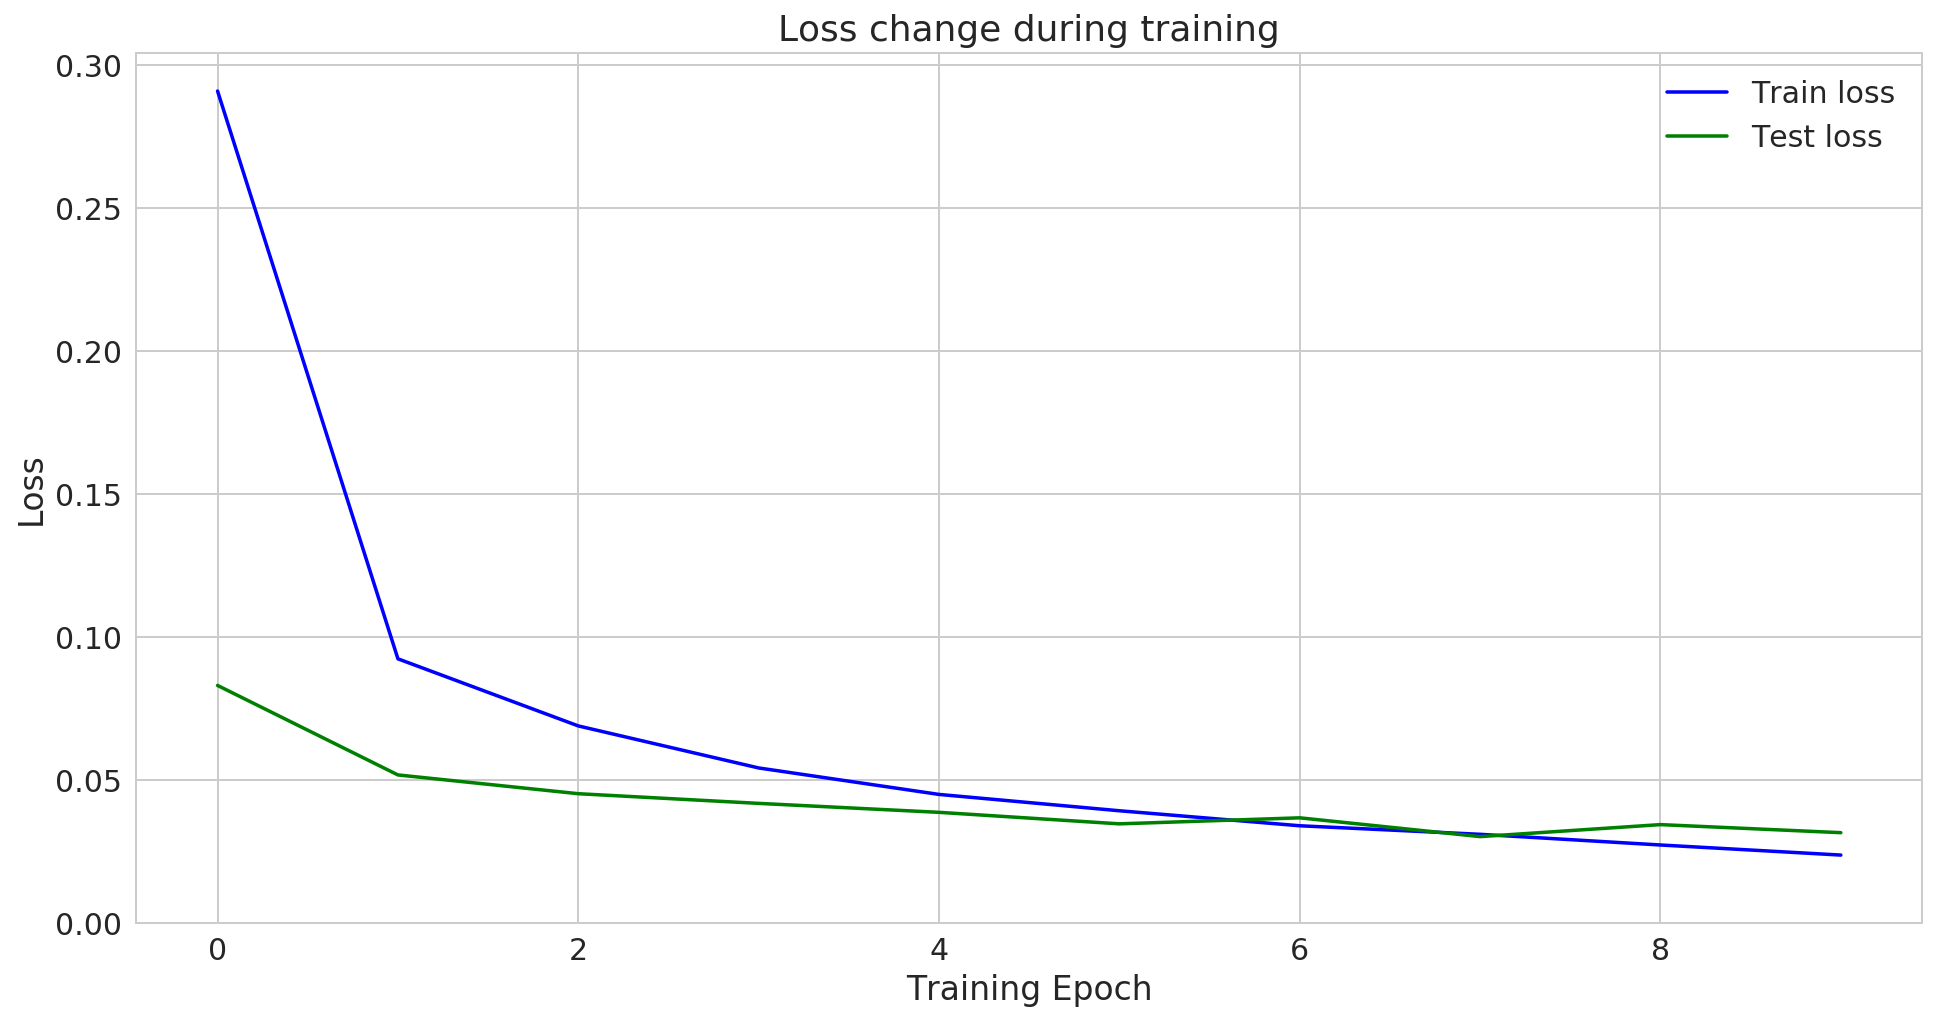

In [82]:
plt.figure(figsize=(16, 8))

plt.plot(train_loss, "b", label="Train loss")

plt.plot(test_loss, "g", label="Test loss")

plt.title("Loss change during training")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show();

In [0]:
model.eval()

ys = []
y_hats = []

for data, target in test_loader:
    data= Variable(data, volatile=True)
    
    if torch.cuda.is_available():
        data = data.cuda()
    
    output = model(data)

    pred = output.data.max(1, keepdim=True)[1]
    
    if torch.cuda.is_available():
        pred = pred.cpu()
    
    pred = pred.numpy().flatten()
    
    y_hats.extend(pred)
    ys.extend(target)

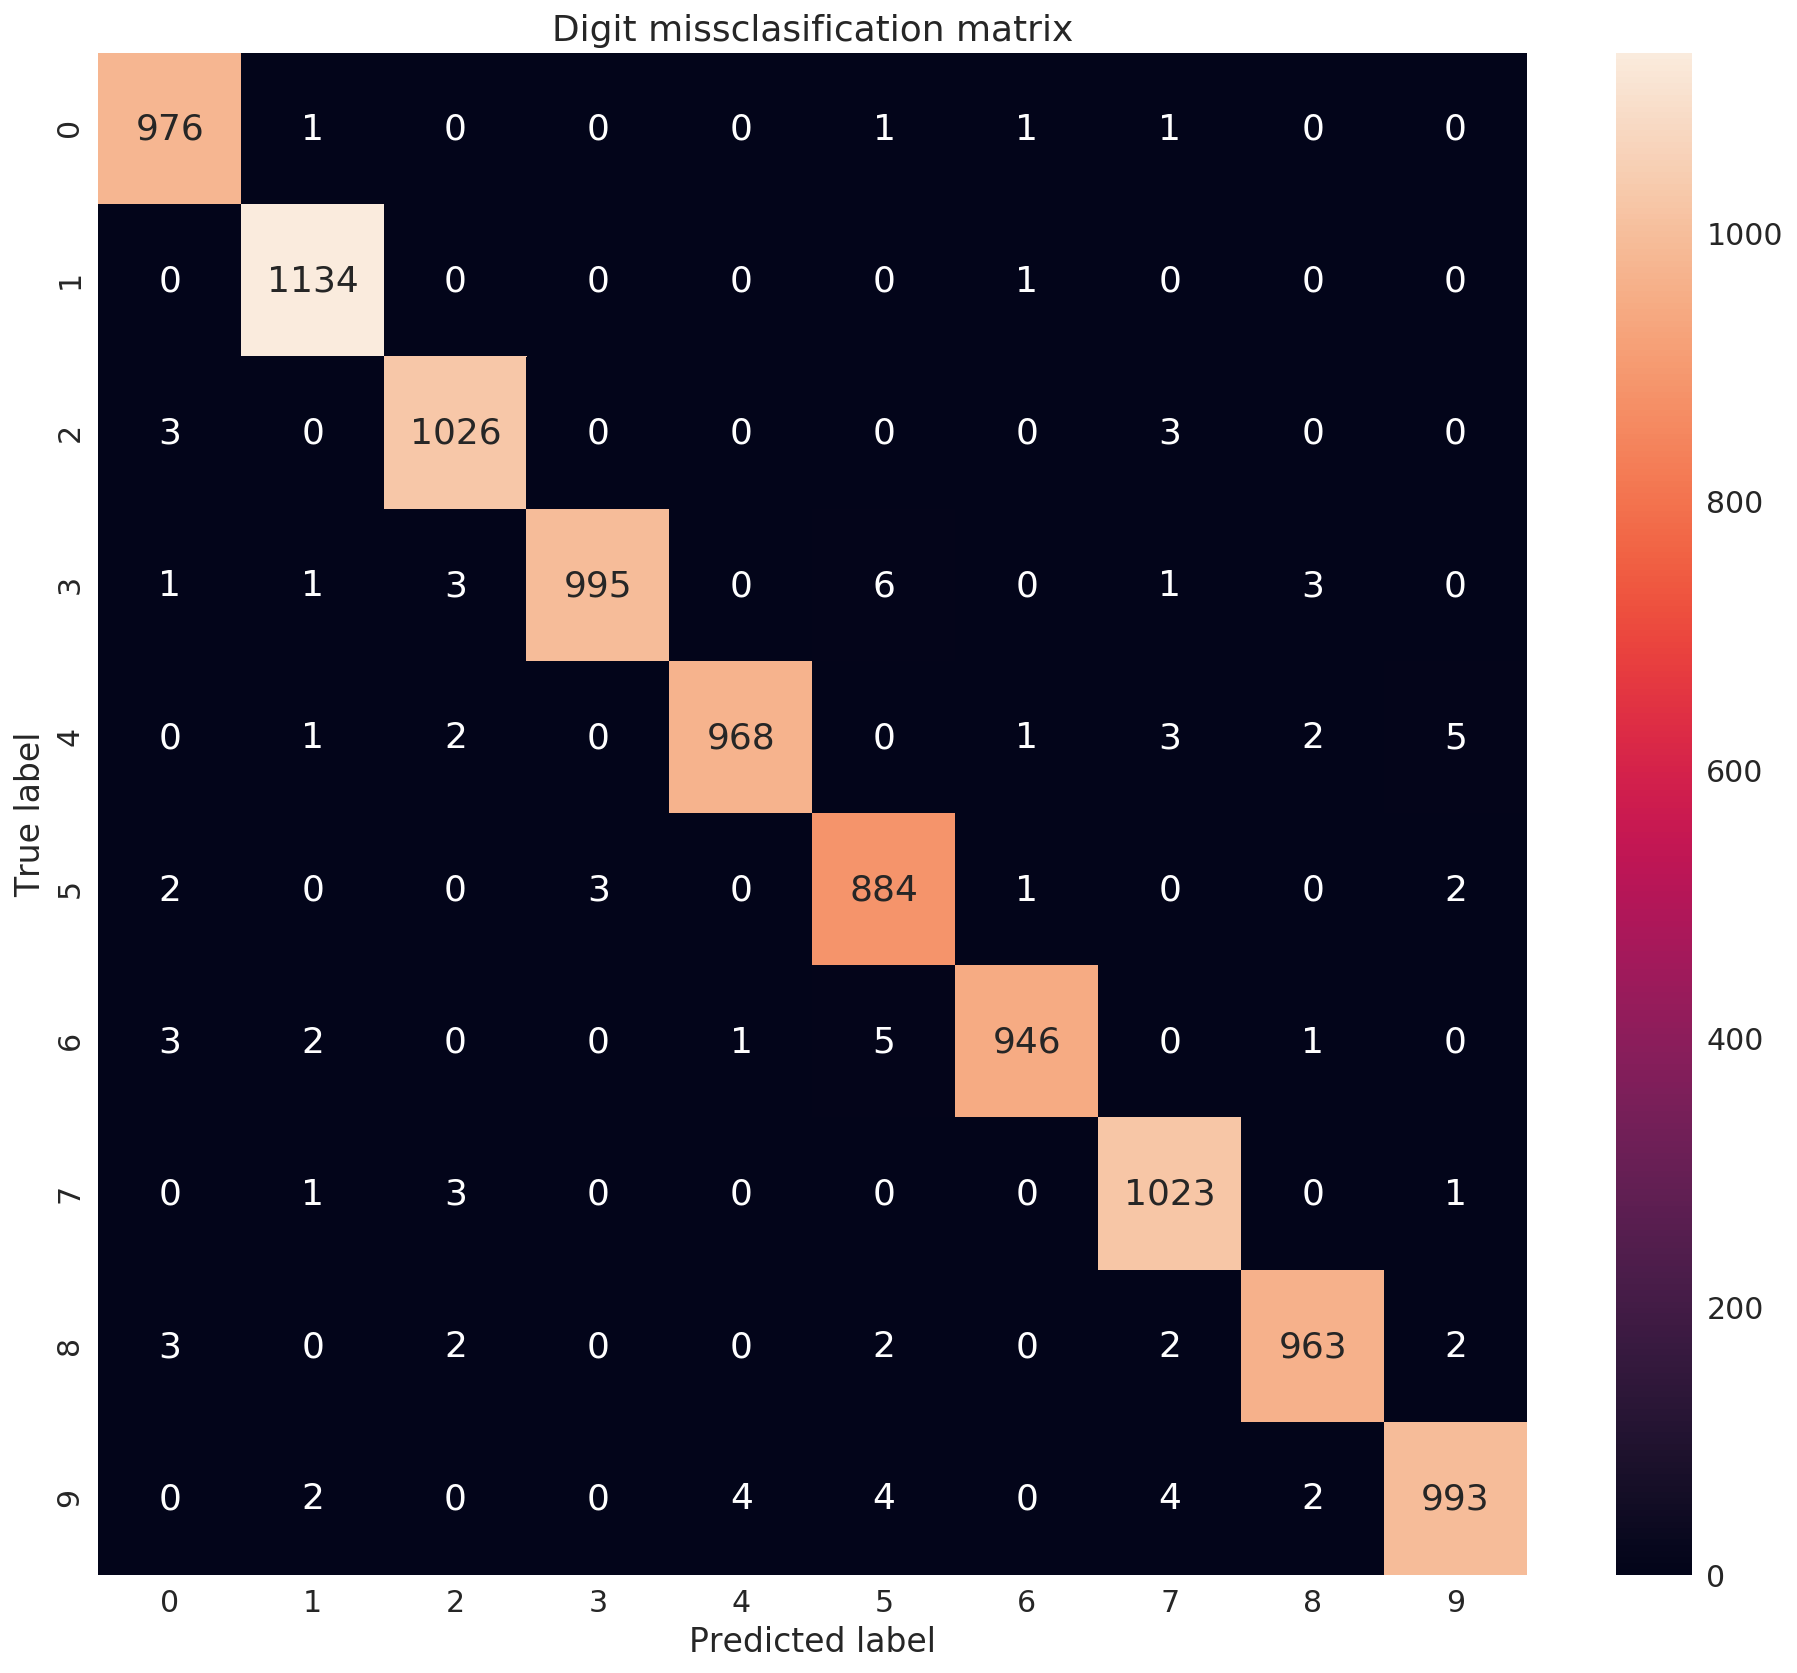

In [84]:
confusion_matrix = metrics.confusion_matrix(ys, y_hats)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d")
plt.title("Digit missclasification matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

# Credits

Thanks to [Arden Dertat](https://medium.com/@ardendertat) for his great images (gifs).